## Task Definition

The goal - to predict if a customer will be converted as the result of some kind of marketing efforts.
 
Dataset description: 
1. Demographic and Financial Attributes:

- **age**: Age of the individual.
- **job, marital, education**: Occupation, marital status, and education level—common demographics in banking.
- **default, housing, loan**: Indicators of financial status, whether they have credit in default, housing loan, or other personal loans.

2. Contact and Campaign-Related Attributes:

- **contact**: Contact communication type, which might indicate if the individual was reached via phone, email, etc.
- **month, day_of_week**: Timing of the contact, which can impact response.
- **duration**: Last contact duration (in seconds); often linked to engagement or interest.
- **campaign**: Number of contacts performed during this campaign.
- **pdays**: Number of days since the client was last contacted from a previous campaign.
- **previous**: Number of contacts performed before this campaign.
- **poutcome**: Outcome of a previous marketing campaign, if any.

3. Economic Indicators:

- **emp_var_rate, cons_price_idx, cons_conf_idx, euribor3m, nr_employed**: Macroeconomic variables such as employment variation rate, consumer price index, consumer confidence index, Euribor 3-month rate, and the number of employees—indicating economic context during the campaign.

4. Target Variable:

- **y**: This is typically the target variable. In many banking datasets, this represents whether the client subscribed to a product as a result of the marketing campaign, such as:
- A term deposit (a common outcome in banking marketing datasets)
- Another financial product, like a loan or credit card

### Initial Setups




In [250]:
# Initial Setups

# Run below commands in terminal but make sure conda is installed or use anaconda prompt which you will get as part of anaconda installation

# 1. ```conda create --prefix /Users/andreikristov/Documents/python/conda_envs/git_mlflow_demo``` it will create a conda env named envname and install python version 3.9 and a ipykernel inside this environment

# 2. Create a symbolic link for environment with long path (it will allow to use short env name as it is locate in default directory):

# ```ln -s /Users/andreikristov/Documents/python/conda_envs/git_mlflow_demo /opt/anaconda3/envs/git_mlflow_demo```

# 3. Activate the environment 
# ```conda activate "/Users/andreikristov/Downloads/(GitHub) MLflow Demo"```
# or
# ```conda activate git_mlflow_demo``` # if it is create in one of the envs_dir

# 4. Install packages ```conda install python=3.9 ipykernel pandas numpy scikit-learn matplotlib seaborn mlflow notebook```

# 5. Install imblearn from pip:

# ```pip install imblearn```

# (to install with pip from current conda env use abs path to pip file from that env)

# If this pure command doesn't work (in my case pip from another virtual env was used, probably because its parth is in .zshrc):

# ```"/Users/andreikristov/Downloads/(GitHub) MLflow Demo/bin/pip" install imblearn```

# 6. add newly created environment to the notebook as kernel 
# ```python -m ipykernel install --user --name=git_mlflow_demo```

# Now open the notebook using below command: (from the anaconda prompt inside conda environment)

# ```jupyter notebook```

### Imports

In [2]:
import os
import time
import logging
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn
import scipy
from scipy.stats import uniform, randint
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from boruta import BorutaPy
import imblearn
import mlflow 
from mlflow import MlflowClient
import mlflow.sklearn
import matplotlib.colors as mcolors
import utils_prj
from utils_prj import *
import importlib
importlib.reload(utils_prj)

warnings.filterwarnings('ignore')
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Suppress the specific warning from XGBoost
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")
# Set MLflow's logger to WARNING level
logging.getLogger("mlflow").setLevel(logging.WARNING)
os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR'] = 'false'

sns.set_style("white")
pd.set_option('display.max_columns', 100)

## Load and Prepare Data

In [3]:
data = pd.read_csv('data/banking.csv')
data_cleaned = clean_data(data)

X, y = data.drop(columns='y'), data[['y']]

columns_num = X.select_dtypes(include=['number']).columns.tolist()
columns_cat = X.select_dtypes(include=['object']).columns.tolist()

transformer_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

transformer_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', transformer_num, columns_num),
    ('cat', transformer_cat, columns_cat)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The dataset is inbalance. We create oversampled version of it to check 
# how algorithms perform on original and oversampled.
# oversample dataset with SMOT
X_train_oversampled, y_train_oversampled = oversample_dataset(X_train, y_train, how='SMOTENC', verbose=False)

# check
X_train_preprocessed = preprocessor.fit_transform(X_train)
columns_cat_preprocessed = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(columns_cat)
columns_preprocessed = columns_num + list(columns_cat_preprocessed)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=columns_preprocessed)
X_train_preprocessed.head()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.094669,0.602794,-0.570006,0.191021,-0.349548,0.839718,1.537852,-0.276872,0.717044,0.844365,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.094669,0.390231,0.160572,0.191021,-0.349548,0.648116,0.722902,0.893416,0.713579,0.329818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.001417,-0.618478,0.160572,0.191021,-0.349548,-1.204035,-0.867202,-1.425489,-1.281812,-0.944759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.001417,-0.432968,0.160572,0.191021,-0.349548,0.839718,1.537852,-0.276872,0.763825,0.844365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.574418,0.053995,-0.204717,0.191021,-0.349548,-2.225911,-1.981486,2.952257,-1.671650,-2.076483,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature Importance

*** plot_feature_importance ***


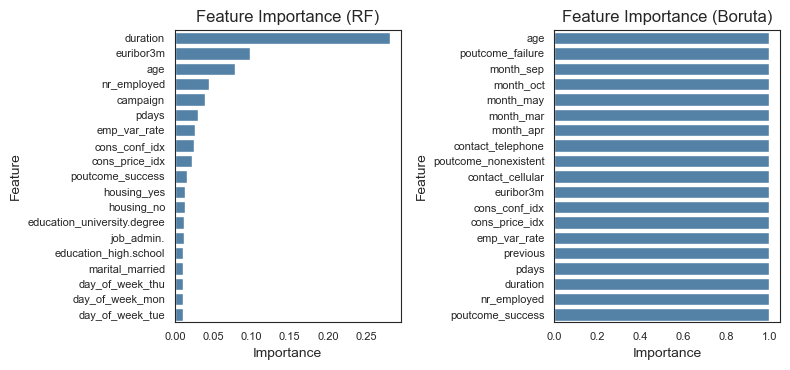

In [309]:
plot_feature_importances(X=X_train_preprocessed, y=y_train, verbose=True)

### Plot Oversampled Data

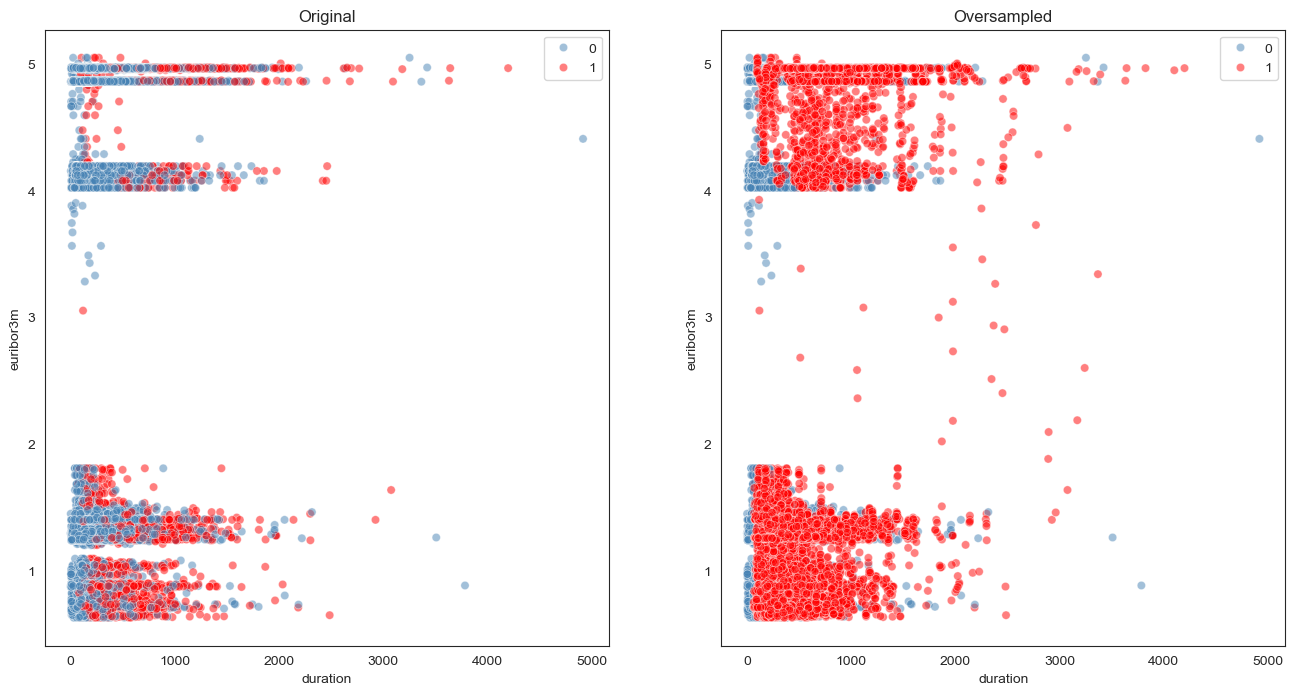

In [6]:
# variables to visualize
vars_vis = ['duration', 'euribor3m']

_, (ax1, ax2) = plt.subplots(figsize=(16,8), ncols=2)
p = {0: 'steelblue', 1: 'red'}
sns.scatterplot(data=X_train, x=vars_vis[0], y=vars_vis[1], hue=y_train.values.ravel(), color='steelblue', alpha=0.5, palette=p, ax=ax1)
sns.scatterplot(data=X_train_oversampled, x=vars_vis[0], y=vars_vis[1], hue=y_train_oversampled.values.ravel(), color='steelblue', alpha=0.5, palette=p, ax=ax2)
ax1.set_title('Original')
ax2.set_title('Oversampled')

plt.show()

## Run Experiments

In [ ]:
# Before logging experiments:
# mlflow server --backend-store-uri "/Users/andreikristov/Documents/repos/ml_projects/Credit Risk (sklearn, NN, mlflow)/mlruns"  --default-artifact-root "/Users/andreikristov/Documents/repos/ml_projects/Credit Risk (sklearn, NN, mlflow)/mlruns" --port 5000

# If we need to clean processes on running on the port:
# lsof -i :5000
# kill -9 <PID1> <PID2> <PID3> ...


# this can be helpful if something is not running
# import os
# os.environ['MLFLOW_ARTIFACT_URI'] = './mlruns'
#del os.environ['MLFLOW_ARTIFACT_URI']
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
#mlflow.set_tracking_uri("file:///Users/andreikristov/Documents/repos/ml_projects/Credit Risk (sklearn, NN, mlflow)/mlruns")

### 1. Shallow Models: Naive Bayes, Logistic Regression, Random Forest, etc.

In [24]:
# Define the models
models = {
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(solver='liblinear'),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNeighbors': KNeighborsClassifier()
}

# Define the parameter grids for RandomizedSearchCV
param_grids = {
    'NaiveBayes': {
        'naivebayes__var_smoothing': [1e-9, 1e-6, 1e-3]  # Three values for var_smoothing
    },
    'LogisticRegression': {
        'logisticregression__C': [0.1, 1, 10],  # Three values for regularization strength
        'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],  # Three values for penalty
        'logisticregression__solver': ['liblinear', 'saga', 'newton-cg'],  # Three solvers for optimization
        'logisticregression__max_iter': [1000] #[100, 200, 300]  # Three values for max_iter
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 200],  # Three values for number of estimators
        'xgboost__learning_rate': [0.01, 0.1, 0.3],  # Three values for learning rate
        'xgboost__max_depth': [3, 5, 7],  # Three values for max depth of trees
        'xgboost__min_child_weight': [1, 3, 5],  # Three values for min child weight
        'xgboost__subsample': [0.7, 0.8, 1],  # Three values for subsample ratio
        'xgboost__colsample_bytree': [0.7, 0.8, 1],  # Three values for column subsample ratio
        'xgboost__gamma': [0, 0.1, 0.2]  # Three values for gamma regularization term
    },
    'SVM': {
        'svm__C': [0.5, 1, 10],  # Three values for regularization parameter
        'svm__kernel': ['linear', 'rbf', 'poly'],  # Three kernel types
        'svm__gamma': ['scale', 'auto', 0.1],  # Three options for gamma
        'svm__degree': [2, 3, 5]  # Three values for degree in polynomial kernel
    },
    'RandomForest': {
        'randomforest__n_estimators': [50, 100, 200],  # Three values for number of trees
        'randomforest__max_depth': [None, 10, 20],  # Three values for max depth of trees
        'randomforest__min_samples_split': [2, 5, 10],  # Three values for min samples to split
        'randomforest__min_samples_leaf': [2, 5, 10],  # Three values for min samples in leaf
        'randomforest__bootstrap': [True, False]  # Whether to use bootstrap sampling
    },
    'GradientBoosting': {
        'gradientboosting__n_estimators': [50, 100, 200],  # Three values for number of trees
        'gradientboosting__learning_rate': [0.01, 0.1, 0.3],  # Three values for learning rate
        'gradientboosting__max_depth': [3, 5, 7],  # Three values for max depth of trees
        'gradientboosting__subsample': [0.7, 0.8, 1],  # Three values for subsample ratio
        'gradientboosting__min_samples_split': [2, 5, 10]  # Three values for min samples to split
    },
    'KNeighbors': {
        'kneighbors__n_neighbors': [3, 5, 7],  # Three values for number of neighbors
        'kneighbors__weights': ['uniform', 'distance'],  # Three options for weights
        'kneighbors__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Four algorithm types
        'kneighbors__p': [1, 2]  # Manhattan (p=1) or Euclidean (p=2) distance
    }
}


# 1. Loop over each model
for exp_id, (model_name, model) in enumerate(models.items()):
 
    print('*'*100)
    print(f'*** Run Model: {model_name}')
    print('*'*100)

    delete_png()
    
    # 2. Loop over model type
    for model_type in ['basic', 'tuned']:

        run_id = 0

        # 3. Loop over dataset type
        for x_type in ['original', 'oversampled']:

            # apply preprocessor (do it separately outside of the main pipeline to be able to make 
            # dimensionality reduction for plotting decision boundary, in case when preprocessing and 
            # model fit are in the same pipeline we need for prediction raw data, but for PCA - preprocessed 
            # (with numeric features only), after applying PCA for prediction we need convert PCA 
            # components to the original features and RAW for feeding into pipeline.. it's a problem)
            if x_type == 'original':
                X_train_ = preprocessor.fit_transform(X_train)
                X_train_ = convert_X_preprocessed_to_dataframe(X_train_, preprocessor, columns_num, columns_cat)
                X_test_ = preprocessor.transform(X_test)
                X_test_ = convert_X_preprocessed_to_dataframe(X_test_, preprocessor, columns_num, columns_cat)
                y_train_ = y_train
            elif x_type == 'oversampled':
                X_train_ = preprocessor.fit_transform(X_train_oversampled)
                X_train_ = convert_X_preprocessed_to_dataframe(X_train_, preprocessor, columns_num, columns_cat)
                X_test_ = preprocessor.transform(X_test)
                X_test_ = convert_X_preprocessed_to_dataframe(X_test_, preprocessor, columns_num, columns_cat)
                y_train_ = y_train_oversampled

            start_time = time.time()
            if model_type == 'basic':
                pipeline = Pipeline(steps=[
                    #('preprocessor', preprocessor),
                    (model_name.lower(), model)])
                # Train the model without tuning (basic model)
                pipeline.fit(X_train_, y_train_.values.ravel())
            elif model_type == 'tuned':
                pipeline_raw = Pipeline(steps=[
                    #('preprocessor', preprocessor),
                    (model_name.lower(), model)])
                # Set up RandomizedSearchCV
                rs = RandomizedSearchCV(
                    pipeline_raw, 
                    param_distributions=param_grids[model_name], 
                    n_iter=10, 
                    scoring='accuracy', 
                    cv=5, 
                    random_state=42, 
                    n_jobs=-1
                )
                rs.fit(X_train_, y_train_.values.ravel())
                pipeline = rs.best_estimator_
            end_time = time.time()
            
            params = pipeline.named_steps[model_name.lower()].get_params()

            # 4. Loop over thresholds
            is_plot_show = True
            for thr in [0.5, 'optimal']:

                threshold_roc_auc = thr
                
                y_pred, y_pred_proba, threshold_roc_auc_optimal = predict_model(model=pipeline, X=X_test_, y=y_test.values.ravel(), threshold=threshold_roc_auc, verbose=False)
                metrics = get_metrics(y_true=y_test.values.ravel(), y_pred=y_pred, y_pred_proba=y_pred_proba, verbose=False)
                metrics.update({'fitting_time_s': end_time - start_time})
                
                plot_roc_auc(y_test.to_numpy().flatten(), y_pred_proba, verbose=False, show=False, ax=None)
                plot_confusion_matrix(y_test.to_numpy().flatten(), y_pred, verbose=False, show=False, ax=None)
                plot_decision_boundary(model=pipeline, X=X_train_, y=y_train_.values.ravel(), remove_outliers=False, show=False, verbose=False)

                run_params = {
                        'model_name': model_name,
                        'model_type': model_type, 
                        'x_type': x_type,
                        'thr_roc': thr,
                        'thr_roc_optimal': threshold_roc_auc_optimal
                        }
                
                run_id += 1

                # print some logs
                print(f'run_{run_id}: ', run_params)
                print('metrics: ', metrics)
                if thr == 'optimal' and model_type == 'tuned' and x_type == 'original':
                    visualize_artifacts()
                
                # print(f'exp__{model_name}_{model_type}')
                # print(f'run_{run_id:02d}__x_{x_type}__thr_{thr}')
                
                # # 5 Log experiment
                log_experiment(
                    experiment_name = f'exp__{model_name}_{model_type}', 
                    run_name = f"run_{run_id:02d}__x_{x_type}__thr_{str(thr).replace('.','')}", 
                    #run_name = 'run_01__model_default_params__x_train_original',
                    model = pipeline.named_steps[model_name.lower()], 
                    run_metrics = metrics, 
                    run_params = run_params,
                    run_tags = {'ts': datetime.now().strftime('%Y_%m_%d_%H%M%S')},
                    input_example = X_train_.sample(n=100), 
                    run_artifacts_png = get_files_list(directory=os.getcwd(), extensions=['.png']),
                    verbose=True)
                #print('-'*30)
        

****************************************************************************************************
*** Run Model: NaiveBayes
****************************************************************************************************
run_1:  {'model_name': 'NaiveBayes', 'model_type': 'basic', 'x_type': 'original', 'thr_roc': 0.5, 'thr_roc_optimal': 0.1}
metrics:  {'accuracy': 0.81, 'precision': 0.35, 'recall': 0.69, 'f1_score': 0.46, 'matthews_corrcoef': 0.4, 'kappa': 0.37, 'tn': 6058, 'fp': 1237, 'fn': 288, 'tp': 655, 'accuracy_p': 0.694591728525981, 'accuracy_n': 0.8304318026045237, 'auc': 0.84, 'auc_manual': 0.79, 'fitting_time_s': 0.013527154922485352}
experiment_id: 885867441566126648, run_id: 86be7abf0ab64336a5a3c896f39989b4
run_2:  {'model_name': 'NaiveBayes', 'model_type': 'basic', 'x_type': 'original', 'thr_roc': 'optimal', 'thr_roc_optimal': 0.1}
metrics:  {'accuracy': 0.79, 'precision': 0.32, 'recall': 0.76, 'f1_score': 0.45, 'matthews_corrcoef': 0.39, 'kappa': 0.34, 'tn': 5757, '

KeyboardInterrupt: 

### 2. Deep Models: simple NN

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,209 (24.25 KB)

 Trainable params: 6,209 (24.25 KB)

 Non-trainable params: 0 (0.00 B)

None
thr:  0.5
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


2024/11/12 12:40:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


run_1:  {'model_name': 'NN', 'model_type': 'basic', 'x_type': 'original', 'thr_roc': 0.5}
metrics:  {'accuracy': 0.91, 'precision': 0.62, 'recall': 0.53, 'f1_score': 0.57, 'matthews_corrcoef': 0.53, 'kappa': 0.52, 'tn': 6995, 'fp': 300, 'fn': 443, 'tp': 500, 'accuracy_p': 0.5302226935312832, 'accuracy_n': 0.9588759424263193, 'auc': 0.94, 'auc_manual': 0.91, 'fitting_time_s': 8.829450845718384}


2024/11/12 12:40:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


experiment_id: 145718438761860565, run_id: 9d19cface8fb4ad98cc5602c0894da63
thr:  optimal
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
run_2:  {'model_name': 'NN', 'model_type': 'basic', 'x_type': 'original', 'thr_roc': 'optimal'}
metrics:  {'accuracy': 0.84, 'precision': 0.42, 'recall': 0.92, 'f1_score': 0.57, 'matthews_corrcoef': 0.55, 'kappa': 0.49, 'tn': 6074, 'fp': 1221, 'fn': 75, 'tp': 868, 'accuracy_p': 0.9204665959703076, 'accuracy_n': 0.83262508567512, 'auc': 0.94, 'auc_manual': 0.91, 'fitting_time_s': 8.829450845718384}


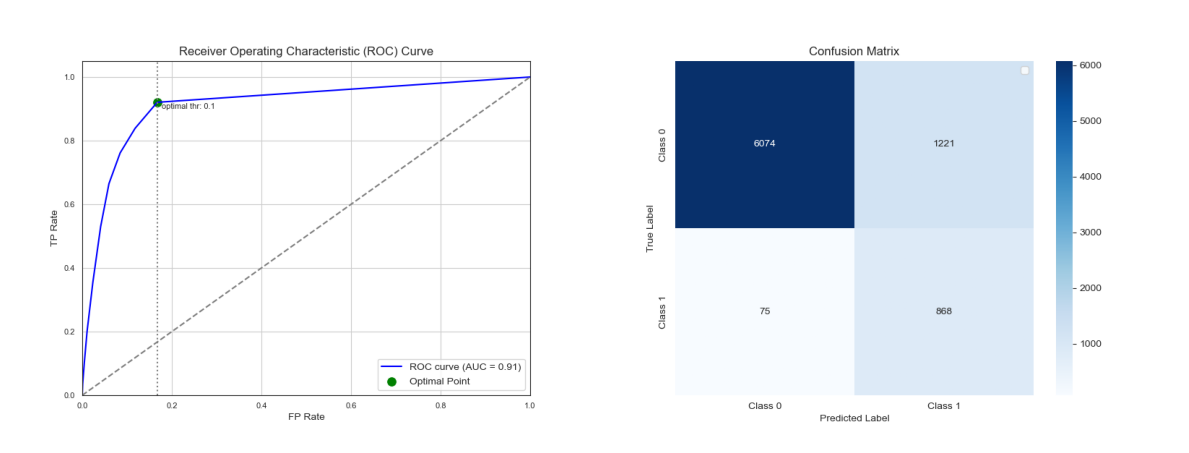

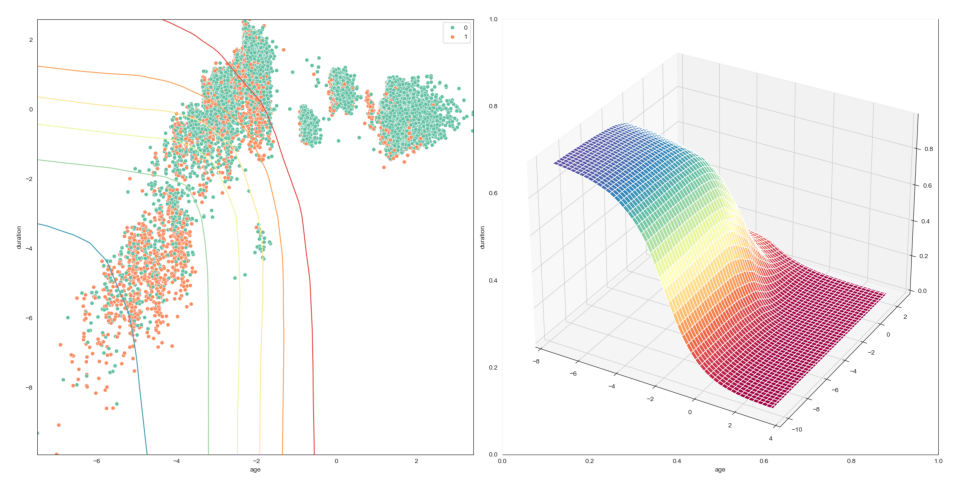

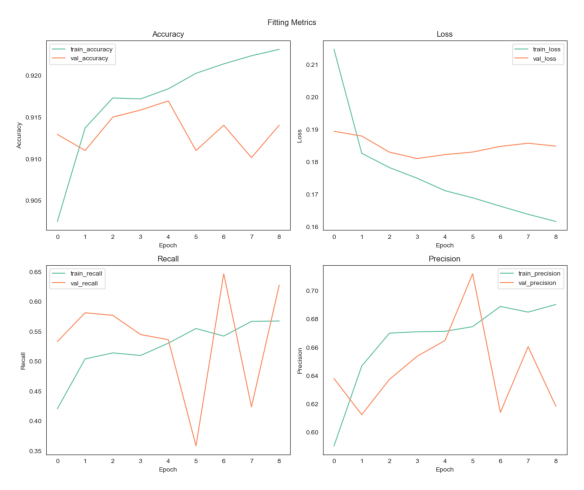

2024/11/12 12:40:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/12 12:40:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


experiment_id: 145718438761860565, run_id: fe3155b41ca943ca9fb1a9cb04930e5d


In [11]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model_name = 'NN'
model_type = 'basic'
x_type = 'original'
run_id = 0


model_NN = build_model_NN(input_shape=X_train_preprocessed.shape[1], output_shape=1)

# Compile the model
model_NN.compile(optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate 0.001
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy','recall', 'precision', 'f1_score'])  # Track accuracy

print(model_NN.summary())

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
start_fit_time = time.time()
history = model_NN.fit(
    X_train_preprocessed, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.25,
    #validation_data=(X_val, y_val), 
    callbacks=[early_stopping],  # Apply early stopping
    verbose=False
)
end_fit_time = start_time = time.time()

history_df = pd.DataFrame(history.history)
history_df = clean_history(history_df=history_df)

metrics_history = get_metrics_from_history(history_df=history_df)

X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=columns_preprocessed)

for thr in [0.5, 'optimal']:
    
    print('thr: ', thr)
    threshold_roc_auc = thr

    y_pred, y_pred_proba, threshold_roc_auc_optimal = predict_model_NN(model=model_NN, X=X_test_preprocessed, y=y_test.values.ravel(), threshold=threshold_roc_auc, verbose=False)
    metrics = get_metrics(y_true=y_test.values.ravel(), y_pred=y_pred, y_pred_proba=y_pred_proba, verbose=False)
    #metrics_model = {'test_' + k: v for k, v in metrics_model.items()}
    
    metrics.update({'fitting_time_s': end_fit_time - start_fit_time})

    delete_png()
    plot_roc_auc(y_test.to_numpy().flatten(), y_pred_proba, verbose=False, show=False, ax=None)
    plot_confusion_matrix(y_test.to_numpy().flatten(), y_pred, verbose=False, show=False, ax=None)
    plot_decision_boundary(model=model_NN, X=X_train_preprocessed, y=y_train.values.ravel(), remove_outliers=False, show=False, verbose=False)
    plot_metrics_vs_epoch_2(history_df, metrics=['accuracy', 'loss', 'recall', 'precision'], file_name='metrics_vs_epochs', verbose=False)

    run_params = {
        'model_name': model_name,
        'model_type': model_type, 
        'x_type': x_type,
        'thr_roc': thr}
                
    run_id += 1

    # print some logs
    print(f'run_{run_id}: ', run_params)
    print('metrics: ', metrics)
    if thr == 'optimal' and x_type == 'original':
        visualize_artifacts()
                  
    # 5 Log experiment
    log_experiment(
        experiment_name = f'exp__{model_name}_{model_type}', 
        run_name = f"run_{run_id:02d}__x_{x_type}__thr_{str(thr).replace('.','')}", 
        model = model_NN, 
        run_metrics = metrics, 
        run_params = run_params,
        run_tags = {'ts': datetime.now().strftime('%Y_%m_%d_%H%M%S')},
        input_example = X_train_preprocessed.sample(n=100), 
        run_artifacts_png = get_files_list(directory=os.getcwd(), extensions=['.png']),
        verbose=True)


## Analyse Experiments

Summarise all model runs.

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# Function to apply color gradient with custom midpoint
def fit_time_gradient(val):
    if pd.isna(val):
        return 'background-color: lightgrey; color: black'
    # Normalize the value with the median as midpoint
    norm = mcolors.TwoSlopeNorm(vmin=mlflow_results["fitting_time_s"].min(), vcenter=mlflow_results["fitting_time_s"].median(), vmax=mlflow_results["fitting_time_s"].max())
    color = green_red_cmap(norm(val))
    return f'background-color: {mcolors.to_hex(color)}; color: black'

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mlflow_results = mlflow.search_runs(search_all_experiments=True)
mlflow_results = mlflow_results[
    ['params.model_name']
    + ['tags.mlflow.runName'] 
    + sorted([c for c in mlflow_results.columns if c.startswith('metrics') if c not in ['metrics.tp', 'metrics.tn', 'metrics.fp', 'metrics.fn', 'metrics.fitting_time_s']]) 
    + ['metrics.fitting_time_s']
    + [c for c in mlflow_results.columns if c.startswith('params') if c not in ['params.model_name']] 
    #+ [c for c in mlflow_results.columns if c.startswith('tags') and c not in ['tags.mlflow.log-model.history', 'tags.mlflow.source.name']]  
    + ['run_id', 'experiment_id']
    #+ ['status', 'artifact_uri', 'start_time', 'end_time']
    ]
mlflow_results.rename({'tags.mlflow.runName': 'run_name', 'params.model_name': 'model_name'}, inplace=True, axis=1)
#mlflow_results = mlflow_results.astype({'metrics.fiting_time_s': float})
mlflow_results = mlflow_results.sort_values(by=['model_name', 'run_name'])
mlflow_results.columns = [c.replace('metrics.', '') if c.startswith('metrics.') else c for c in mlflow_results.columns]

mlflow_results = mlflow_results.sort_values(by='recall', ascending=False)#.query('`params.thr_roc` == "optimal"')
mlflow_results

# style output table
orange_cmap = LinearSegmentedColormap.from_list("orange_cmap", ["#ffffff", "#F9CB9C"])
# Define a custom color map from green to white to red
green_red_cmap = LinearSegmentedColormap.from_list("green_red_cmap", ["#A5D8A5", '#FFFFFF', "#F7A7A7"]) # , green-yellow-red ["#A5D8A5", "#F9E79F", "#F7A7A7"]


mlflow_results[mlflow_results.select_dtypes(include='float64').columns] = mlflow_results[mlflow_results.select_dtypes(include='float64').columns].round(3)


# Select only numeric columns
numeric_columns = mlflow_results.select_dtypes(include="number").columns

# Apply background gradient to numeric columns
mlflow_results_styled = (mlflow_results.style
                         .format({col: '{:,.3f}' for col in mlflow_results.select_dtypes(include='float').columns})
                         .set_properties(**{'background-color': 'white'})  # Set whole background to white
                         .set_table_styles([
                             {'selector': 'thead th', 'props': [('background-color', 'white'), ('color', 'black')]},  # Header background
                             {'selector': 'th.row_heading', 'props': [('background-color', 'white')]},  # Index column background
                             {'selector': 'td.col0', 'props': [('text-align', 'left')]},
                             {'selector': 'td.col1', 'props': [('text-align', 'left')]}])
                         .background_gradient(cmap=orange_cmap, subset=numeric_columns)
                         .applymap(fit_time_gradient, subset=["fitting_time_s"])  # Custom gradient for "fit_time"
                         .applymap(lambda x: 'background-color: #dddddd' if pd.isna(x) else '', subset=numeric_columns)  # Set light grey for NA
                         .set_properties(**{'color': 'black'})
                        )



mlflow_results_styled

,model_name,run_name,accuracy,accuracy_n,accuracy_p,auc,auc_manual,f1_score,kappa,matthews_corrcoef,precision,recall,fitting_time_s,params.x_type,params.model_type,params.thr_roc,params.thr_roc_optimal,run_id,experiment_id
22,RandomForest,run_04__x_oversampled__thr_optimal,0.820,0.800,0.960,0.940,0.930,0.550,0.460,0.530,0.380,0.960,3.594,oversampled,basic,optimal,0.1,54d7d10f77d640848bfa8504b78ab7f0,468903028960556398
20,RandomForest,run_02__x_original__thr_optimal,0.830,0.820,0.950,0.940,0.930,0.570,0.490,0.550,0.410,0.950,32.327,original,tuned,optimal,0.1,5c1957309c144658ac8d030aac9c7a8a,888814970028867148
36,XGBoost,run_02__x_original__thr_optimal,0.850,0.832,0.943,0.950,0.930,0.580,0.500,0.570,0.420,0.940,6.471,original,tuned,optimal,0.1,4f689513820a41938f7a3f325f0d687a,969549717083554156
12,GradientBoosting,run_02__x_original__thr_optimal,0.860,0.846,0.930,0.950,0.920,0.600,0.520,0.580,0.440,0.930,104.529,original,tuned,optimal,0.1,5023ab27b751466f98b0ae6c0d89d7d6,469193029448780758
18,RandomForest,run_04__x_oversampled__thr_optimal,0.850,0.839,0.930,0.940,0.930,0.590,0.510,0.570,0.430,0.930,42.909,oversampled,tuned,optimal,0.2,5d86943d1e844ec4b68d64109f9c321f,888814970028867148
24,RandomForest,run_02__x_original__thr_optimal,0.840,0.825,0.931,0.940,0.920,0.570,0.480,0.550,0.410,0.930,2.533,original,basic,optimal,0.1,8df5b390357346da8bd2e7579ea70ee7,468903028960556398
38,XGBoost,run_04__x_oversampled__thr_optimal,0.850,0.837,0.934,0.940,0.920,0.580,0.510,0.570,0.430,0.930,0.515,oversampled,basic,optimal,0.1,617f61b9287744f59aee12f34ad6cf34,518432335208327326
16,GradientBoosting,run_02__x_original__thr_optimal,0.850,0.841,0.925,0.950,0.920,0.590,0.510,0.570,0.430,0.920,5.340,original,basic,optimal,0.1,d9858570f3324eb0818d9afe3d1b9efb,294818963585985929
0,NN,run_02__x_original__thr_optimal,0.840,0.833,0.920,0.940,0.910,0.570,0.490,0.550,0.420,0.920,8.829,original,basic,optimal,None,fe3155b41ca943ca9fb1a9cb04930e5d,145718438761860565
10,GradientBoosting,run_04__x_oversampled__thr_optimal,0.850,0.843,0.917,0.940,0.910,0.590,0.510,0.560,0.430,0.920,162.097,oversampled,tuned,optimal,0.1,2fdb233c7de14966950d7a88022b45c7,469193029448780758


### Goose the model. Load and Test it.

In [16]:
#mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_tracking_uri("file:///Users/andreikristov/Documents/repos/ml_projects/Effect of the Bank Marketing Campaign (sklearn, NN, mlflow)/mlruns")

In [17]:
# select a model from the run
# we are maximazing Recall
# we select Random Forest with Recall 0.950 and Precision 0.410

run_id_selected = '54d7d10f77d640848bfa8504b78ab7f0' # corresponds na=64, ns=64, and test_accuracy = 0.99
run = mlflow.get_run(run_id_selected)
run_params = run.data.params
print('run_params: ', run_params)
threshold_optimal = run_params.get('thr_roc_optimal')

# Load model from MLflow Tracking
model_ = mlflow.sklearn.load_model(f"runs:/{run_id_selected}/model")
# Predict and get metrics
y_pred, y_pred_proba, threshold_roc_auc = predict_model(model=model_, X=X_test_preprocessed, y=None, threshold=float(threshold_optimal), verbose=False)
metrics = get_metrics(y_true=y_test.values.ravel(), y_pred=y_pred, y_pred_proba=y_pred_proba, verbose=False)
print('metrics: ', metrics)

run_params:  {'thr_roc_optimal': '0.1', 'model_name': 'RandomForest', 'x_type': 'oversampled', 'model_type': 'basic', 'thr_roc': 'optimal'}


OSError: No such file or directory: '/Users/andreikristov/Documents/repos/ml_projects/Credit Risk (sklearn, NN, mlflow)/mlruns/468903028960556398/54d7d10f77d640848bfa8504b78ab7f0/artifacts/model'

### Register selected model, prepare for Productizing

In [ ]:
from mlflow import MlflowClient

# Create an instance of MLflow Client Class named client
client = MlflowClient()

# Create new model
#client.create_registered_model(name="Banking")

mlflow.register_model(model_uri=f"runs:/{run_id_selected}/model", name="Predict_credict", tags={'stage':'staging'})

### Ad-hoc

<Axes: >

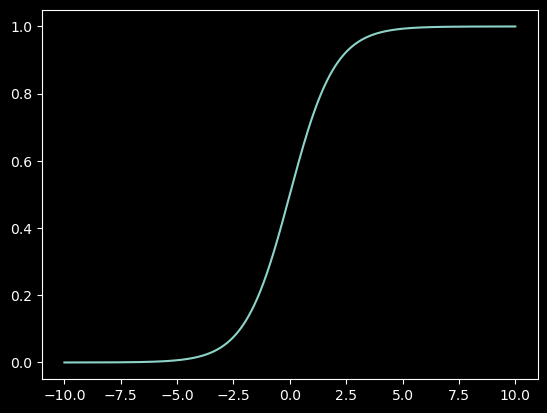

In [280]:
import seaborn as sns
x = np.linspace(-10,10, num=1000)
y = np.exp(x) / (1 + np.exp(x))
sns.lineplot(x=x,y=y)

In [11]:
# unify column names
df = pd.DataFrame({'Abs Cde': [1,2,3], 'drt': [4,5,6], 'dfg_tyu': [7,0,9]})
df.columns = df.columns.str.replace(r'[\.\s]','_', regex=True).str.lower()
df

,abs_cde,drt,dfg_tyu
0,1,4,7
1,2,5,0
2,3,6,9


In [259]:
# unpack dictionary
d = {'model_type': 'Random Forest', 'desc': 'baseline'}
#d=None
print(type(d))
if d:
    for item in d.items():
        print(item[0], item[1])
        #print(item.key(), item.value())

    for item in d:
        print(type(item))
        print(item)
        print(d[item])
        #print(item[0], item[1])

TypeError: 'str' object is not callable

In [ ]:
# set function args with dictionary
params = {'n_estimators': 100, 'max_depth': 5}
def f(n_estimators, max_depth):
    print(n_estimators, max_depth)
f(**params)

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Parameters for generating data
num_entries = 5
start_date = datetime(2024, 10, 12)
date_list = [start_date + timedelta(days=np.random.randint(1, 15)) for _ in range(num_entries)]

# Generating fake data
data = {
    'Date': [date.strftime('%Y%m%d') for date in date_list],
    'Users': np.random.randint(75000, 100500, num_entries),
    'ARPU': np.round(np.random.uniform(85, 125, num_entries), 2)
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


       Date  Users    ARPU
0  20241020  77244   88.55
1  20241016  97024  112.74
2  20241021  87593  104.97
3  20241023  90102   93.69
4  20241023  89108   97.47


In [19]:
# earnings when investing in index funds
n_years = 10
return_per_year = 0.09
euro_invested = 10000
result = 10000*(1+0.09)**10
result

23673.63674592119